In [5]:
import pandas as pd
from IPython.display import display, Markdown  # Assuming you use these for display


# Set pandas display options to show more columns and rows
pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.max_rows', 10)       # Limit to 10 rows for readability
pd.set_option('display.width', 1000) 

In [6]:
# process_files.py
from config import date_str, DOWNLOAD_DIR, DEST_DIR
from pathlib import Path  # Better path handling

# Build paths
source_path =f'../data/{date_str}_df_OHLCV_clean.parquet'
print(f"source_path: {source_path}")

source_path: ../data/2025-04-09_df_OHLCV_clean.parquet


In [7]:
df_OHLCV = pd.read_parquet(source_path)
df_OHLCV.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 385536 entries, ('INVH', Timestamp('2025-04-09 00:00:00')) to ('GD', Timestamp('2024-04-10 00:00:00'))
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Open       385536 non-null  float64
 1   High       385536 non-null  float64
 2   Low        385536 non-null  float64
 3   Close      385536 non-null  float64
 4   Adj Close  385536 non-null  float64
 5   Volume     385536 non-null  Int64  
 6   Adj Open   385536 non-null  float64
 7   Adj High   385536 non-null  float64
 8   Adj Low    385536 non-null  float64
dtypes: Int64(1), float64(8)
memory usage: 28.4+ MB


Processing 7 unique selection dates...
--- Calculation Summary ---
Total selection dates processed: 7
Skipped selections (no implementation date): 1
Skipped selections (no evaluation date): 1
Instances of missing/zero prices for individual stocks: 0
Calculated returns for 5 dates.
---------------------------

--- Portfolio Daily Returns ---
(Index represents the 'Evaluation Date' - the date the return is calculated for, based on the change from the previous trading day's close)
Date
2025-04-03    0.009101
2025-04-04   -0.050753
2025-04-07   -0.018254
2025-04-08   -0.001395
2025-04-09   -0.000872
Name: Portfolio Daily Return, dtype: float64

--- Portfolio Cumulative Returns ---
(Index represents the 'Evaluation Date')
Date
2025-04-03    0.009101
2025-04-04   -0.042114
2025-04-07   -0.059600
2025-04-08   -0.060911
2025-04-09   -0.061730
Name: Portfolio Daily Return, dtype: float64


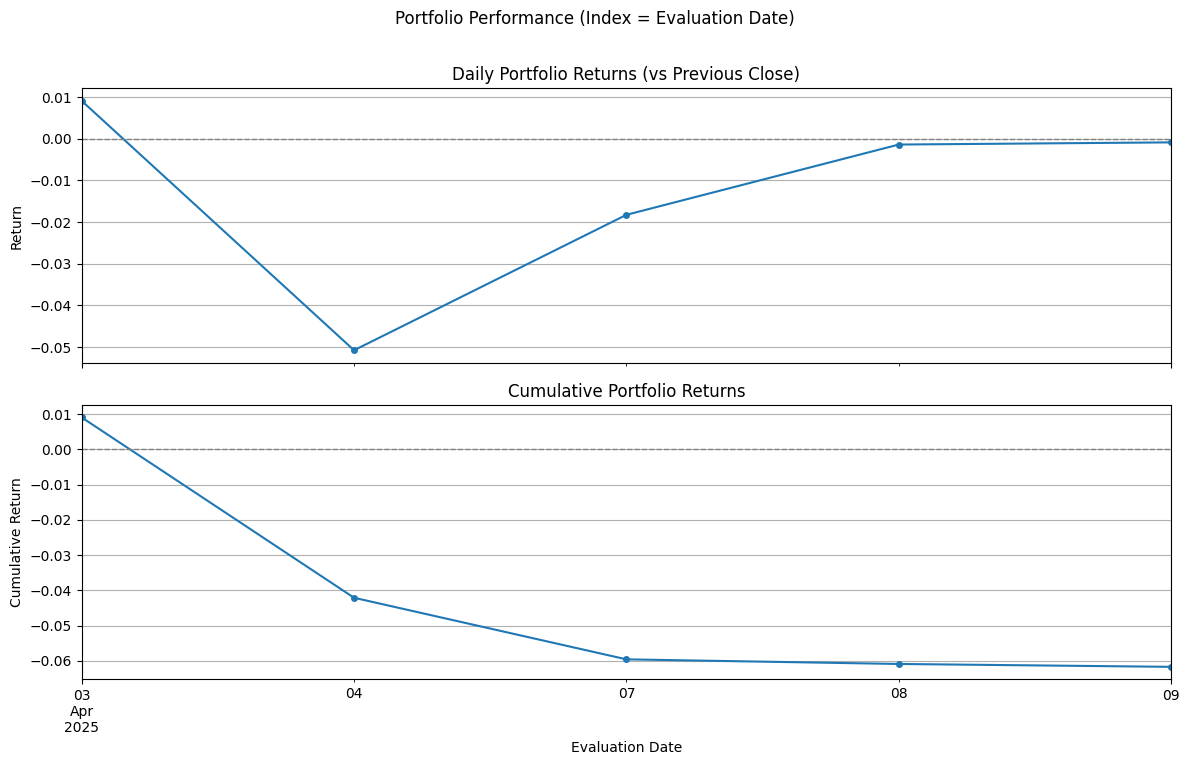

In [8]:
import pandas as pd

def find_next_trading_date(current_date, all_trading_dates):
    """
    Finds the first trading date strictly after the given current_date.

    Args:
        current_date (pd.Timestamp): The date after which to find the next trading date.
        all_trading_dates (pd.DatetimeIndex): A sorted Series/Index of all available trading dates.

    Returns:
        pd.Timestamp or None: The next trading date, or None if not found.
    """
    # Find the index where the current_date would be inserted to maintain order
    idx = all_trading_dates.searchsorted(current_date, side='right')
    if idx < len(all_trading_dates):
        return all_trading_dates[idx]
    else:
        # No trading date found after current_date
        return None

def calculate_portfolio_performance(selections_file, df_ohlcv):
    """
    Calculates the daily returns of portfolios based on historical selections.

    Args:
        selections_file (str): Path to the stock_selections_history.csv file.
        df_ohlcv (pd.DataFrame): DataFrame with OHLCV data, indexed by (Ticker, Date).

    Returns:
        pd.Series: A Series containing the daily portfolio returns, indexed by date.
                   Returns None if inputs are invalid or data is missing.
    """
    # --- 1. Load and Prepare Selections Data ---
    try:
        selections_df = pd.read_csv(selections_file)
        selections_df['Date'] = pd.to_datetime(selections_df['Date'])
        # Ensure weights sum to approximately 1 for each date (optional check)
        # print(selections_df.groupby('Date')['Weight'].sum())
    except FileNotFoundError:
        print(f"Error: Selections file not found at {selections_file}")
        return None
    except Exception as e:
        print(f"Error reading selections file: {e}")
        return None

    # --- 2. Prepare Price Data ---
    if not isinstance(df_ohlcv.index, pd.MultiIndex):
        print("Error: df_ohlcv must have a MultiIndex (Ticker, Date).")
        return None
    if not isinstance(df_ohlcv.index.levels[1], pd.DatetimeIndex):
         print("Warning: Converting Date level of df_ohlcv index to DatetimeIndex.")
         # Create a new index with the date level converted
         ticker_level = df_ohlcv.index.get_level_values(0)
         date_level = pd.to_datetime(df_ohlcv.index.get_level_values(1))
         df_ohlcv.index = pd.MultiIndex.from_arrays([ticker_level, date_level], names=['Ticker', 'Date'])
         df_ohlcv = df_ohlcv.sort_index() # Sort after potential conversion

    # Get all unique trading dates from the price data, sorted
    all_trading_dates = df_ohlcv.index.get_level_values('Date').unique().sort_values()

    # --- 3. Calculate Daily Returns ---
    portfolio_daily_returns = {}
    skipped_dates_no_next = 0
    skipped_dates_no_eval = 0
    missing_price_count = 0

    # Group selections by the date the selection was made
    grouped_selections = selections_df.groupby('Date')

    print(f"Processing {len(grouped_selections)} unique selection dates...")

    for selection_date, group in grouped_selections:
        # Find the next trading day *after* the selection date (Implementation Date)
        implementation_date = find_next_trading_date(selection_date, all_trading_dates)
        if implementation_date is None:
            # print(f"Warning: No trading day found after selection date {selection_date}. Skipping.")
            skipped_dates_no_next += 1
            continue

        # Find the trading day *after* the implementation date (Evaluation Date)
        evaluation_date = find_next_trading_date(implementation_date, all_trading_dates)
        if evaluation_date is None:
            # print(f"Warning: No trading day found after implementation date {implementation_date} (for selection {selection_date}). Skipping.")
            skipped_dates_no_eval += 1
            continue

        # This is the date for which we are calculating the return
        return_date = evaluation_date
        daily_return = 0.0

        # Iterate through stocks selected on this date
        for _, row in group.iterrows():
            ticker = row['Ticker']
            weight = row['Weight']

            try:
                # Get price at the close of the implementation date (our conceptual 'buy' price)
                price_implementation = df_ohlcv.loc[(ticker, implementation_date), 'Adj Close']

                # Get price at the close of the evaluation date (our conceptual 'sell' price)
                price_evaluation = df_ohlcv.loc[(ticker, evaluation_date), 'Adj Close']

                # Calculate individual stock return for the period
                if pd.notna(price_implementation) and pd.notna(price_evaluation) and price_implementation != 0:
                    stock_return = (price_evaluation / price_implementation) - 1
                    daily_return += weight * stock_return
                else:
                     # print(f"Warning: Missing or zero price for {ticker} on {implementation_date} or {evaluation_date}. Skipping contribution.")
                     missing_price_count += 1

            except KeyError:
                # print(f"Warning: Price data not found for {ticker} on {implementation_date} or {evaluation_date}. Skipping contribution.")
                missing_price_count += 1
            except Exception as e:
                print(f"Error processing {ticker} for {selection_date}: {e}")
                missing_price_count += 1


        # Store the calculated portfolio return for the evaluation date
        if return_date in portfolio_daily_returns:
             print(f"Warning: Overwriting return for date {return_date}. Check selection dates.")
        portfolio_daily_returns[return_date] = daily_return

    print("--- Calculation Summary ---")
    print(f"Total selection dates processed: {len(grouped_selections)}")
    print(f"Skipped selections (no implementation date): {skipped_dates_no_next}")
    print(f"Skipped selections (no evaluation date): {skipped_dates_no_eval}")
    print(f"Instances of missing/zero prices for individual stocks: {missing_price_count}")
    print(f"Calculated returns for {len(portfolio_daily_returns)} dates.")
    print("---------------------------")


    # --- 4. Format and Return Results ---
    if not portfolio_daily_returns:
        print("Warning: No portfolio returns were calculated.")
        return pd.Series(dtype=float)

    returns_series = pd.Series(portfolio_daily_returns).sort_index()
    returns_series.index.name = 'Date'
    returns_series.name = 'Portfolio Daily Return'

    return returns_series


# # 2. Define the path to your selections file
selections_csv_path = 'stock_selections_history.csv'

# 3. Calculate performance
portfolio_returns = calculate_portfolio_performance(selections_csv_path, df_OHLCV)


# 4. Display results
if portfolio_returns is not None:
    print("\n--- Portfolio Daily Returns ---")
    # Add clarification here:
    print("(Index represents the 'Evaluation Date' - the date the return is calculated for, based on the change from the previous trading day's close)")
    print(portfolio_returns)

    # --- Optional: Calculate Cumulative Returns ---
    if not portfolio_returns.empty:
        cumulative_returns = (1 + portfolio_returns).cumprod() - 1
        print("\n--- Portfolio Cumulative Returns ---")
        # Add clarification here too, if desired:
        print("(Index represents the 'Evaluation Date')")
        print(cumulative_returns)

        # --- Optional: Plotting ---
        # ... (plotting code remains the same, titles could also be updated) ...
        try:
            import matplotlib.pyplot as plt
            fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

            portfolio_returns.plot(ax=ax[0], title='Daily Portfolio Returns (vs Previous Close)', grid=True, style='-o', ms=4) # Updated title
            ax[0].set_ylabel("Return")
            ax[0].set_xlabel("Evaluation Date") # Updated label
            ax[0].axhline(0, color='grey', linestyle='--', lw=1)

            cumulative_returns.plot(ax=ax[1], title='Cumulative Portfolio Returns', grid=True, style='-o', ms=4)
            ax[1].set_ylabel("Cumulative Return")
            ax[1].set_xlabel("Evaluation Date") # Updated label
            ax[1].axhline(0, color='grey', linestyle='--', lw=1)

            plt.suptitle("Portfolio Performance (Index = Evaluation Date)") # Overall title
            plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust layout for suptitle
            plt.show()
        except ImportError:
            print("\nInstall matplotlib (pip install matplotlib) to see plots.")
